In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
from pathlib import Path
import geopandas as gpd
import os

# Functions

In [ ]:
# Universally applicable Lisflood TSS Read Function
def read_lisflood_tss(
    out_dir,
    varname,
    start_date,
    n_gauges,
    skiprows,
    freq="D"
):
    """
    Generic reader for LISFLOOD .tss files with varname+runname convention
    If file does not exist, returns NaN DataFrame instead of crashing.
    """
    run_name = out_dir.name
    tss_file = out_dir / f"{varname}{run_name}.tss"

    if not tss_file.exists():
        print(f"⚠️  Missing LISFLOOD file → filled with NaNs: {tss_file}")
        return pd.DataFrame(
            columns=[f"gauge_{i+1}" for i in range(n_gauges)]
        ) 

    df = pd.read_fwf(tss_file, skiprows=skiprows, header=None)
    df.columns = ["date"] + [f"gauge_{i+1}" for i in range(n_gauges)]
    df["date"] = pd.date_range(
        start=start_date,
        periods=len(df),
        freq=freq
    )
    return df.set_index("date")

# Read Time Series

In [ ]:
# Start Date
# start_date = '01/01/1996 00:00'
start_date = "01/01/1975 00:00"

# Read Data
WORK_DIR = Path(Path.cwd())
OUT_DIR = WORK_DIR / "out" / "long_term_run"
OBS_DIR = WORK_DIR / "station"
METEO_DIR = Path('./meteo')

run_name = OUT_DIR.name
dis_file = OUT_DIR / f"dis{run_name}.tss"

with open(dis_file) as f:
    lines = f.readlines()

n_gauges = int(lines[1].strip()) - 1
skiprows = 3 + n_gauges

# Obs Q
obs_dis = pd.read_csv(OBS_DIR / 'observations.csv',parse_dates=[0])
obs_dis.columns = ["Date","Discharge"]
obs_dis = obs_dis.set_index("Date") #.drop(columns="date")

# Read Sim (all Vars)
# ETA = ESActPixel+self.var.TaPixel+self.var.TaInterceptionAll+self.var.EvaAddM3*self.var.M3toMM
vars_to_read = {
    "q": "dis",
    "etp": "etUps",
    "eta": "actEvapo", # actEvapo from Peter versus actETP from documentation
    "es": "esActUps",
    "transp": "tActUps",
    "intcpt": "ewIntActUps",
    "rain": "rainUps",
    "snow": "snowUps",
    "smlt": "snowMeltUps",
    "total_runoff": "totalRunoffUps",
    "infil": "infiltrationUps",
    "qb_up": "qUzUps",
    "qb_low": "qLzUps",
}

lf = {}

for key, var in vars_to_read.items():
    lf[key] = read_lisflood_tss(
        OUT_DIR, var, start_date, n_gauges, skiprows
    )

lf["precip"] = lf["rain"] + lf["snow"]

lf.keys()

/tmp/ipykernel_2727008/1183484657.py:21: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  obs_dis = pd.read_csv(OBS_DIR / 'observations.csv',parse_dates=[0])


⚠️  Missing LISFLOOD file → filled with NaNs: /storage/schafti/Documents/01_Hydrology/01_Lisflood/00_SourceCode/01_Playground/01_Test_Usecase/create_submodel_7859/7859_testing/out/long_term_run/infiltrationUpslong_term_run.tss


dict_keys(['q', 'etp', 'eta', 'es', 'transp', 'intcpt', 'rain', 'snow', 'smlt', 'total_runoff', 'infil', 'qb_up', 'qb_low', 'precip'])

<Axes: xlabel='date'>

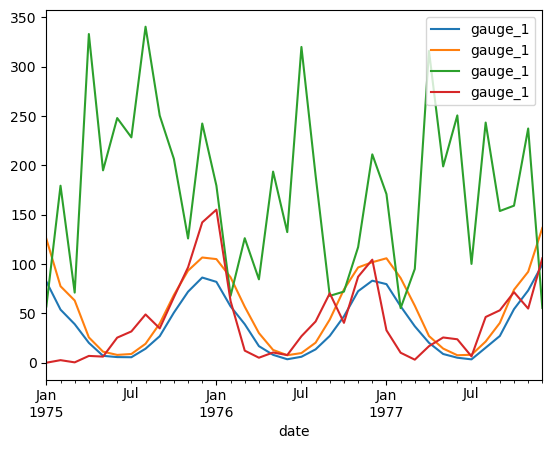

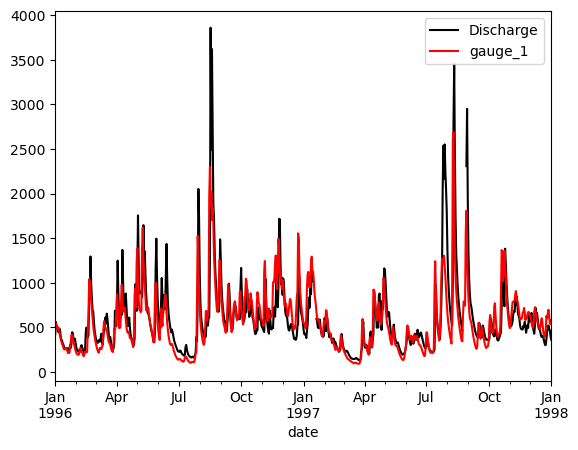

In [9]:
# Quick Evap Check
fig,ax = plt.subplots()
(lf["eta"].resample("MS").sum()).iloc[:12*3].plot(ax=ax,label="ETAsim")
(lf["etp"].resample("MS").sum()).iloc[:12*3].plot(ax=ax,label="ETPsim")
(lf["precip"].resample("MS").sum()).iloc[:12*3].plot(ax=ax,label="PCPsim")
(lf["smlt"].resample("MS").sum()).iloc[:12*3].plot(ax=ax,label="SMLTsim")

# Quick Q Check
fig,ax = plt.subplots()
obs_dis.loc["1996-01-01":"1998-01-01"].plot(ax=ax,label="Qobs",c="k")
lf["q"].loc["01/01/1996":"01/01/1998"].plot(ax=ax,label="Qsim",c="r")


In [ ]:
# fig, ax = plt.subplots(figsize=(8,6))
# obs_dis.plot(ax=ax, label='LISFLOOD Ref', color='black')
# sim_dis.plot(ax=ax, label='LISFLOOD Own', color='blue')
# ax.set_xlabel('Date')
# ax.set_ylabel('Discharge (m³/s)')
# ax.set_title('Discharge Comparison at Gauge Location')
# ax.legend()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(obs_dis.index, obs_dis.values, color='black', label='LISFLOOD Ref')
ax.plot(sim_dis.index, sim_dis.values, color='blue', label='LISFLOOD Own')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.set_title('Discharge Comparison at Gauge Location')
fig.autofmt_xdate()

# Legend
ax.legend()

# Read NC

## Static Inputs

In [ ]:
lf_in = Path('./maps')
lf_in_soil = Path('./soilhyd')

# load soil depths
soilf1 = xr.open_dataset(lf_in_soil / 'soildepth1_f.nc')
soilo1 = xr.open_dataset(lf_in_soil / 'soildepth1_o.nc')
soilf2 = xr.open_dataset(lf_in_soil / 'soildepth2_f.nc')
soilo2 = xr.open_dataset(lf_in_soil / 'soildepth2_o.nc')
soilf3 = xr.open_dataset(lf_in_soil / 'soildepth3_f.nc')
soilo3 = xr.open_dataset(lf_in_soil / 'soildepth3_o.nc')

# load dem 
dem = xr.open_dataset(lf_in/"dem.nc")

# load upstream area map
uparea = xr.open_dataset(lf_in / 'upArea.nc') 
# uparea = uparea.drop_vars('crs')
uparea = uparea.where(uparea >= 0, np.nan)
uparea /= 1e6 # km2

# load local drainage direction map
ldd = xr.open_dataset(lf_in /'ldd.nc')
# ldd = ldd.drop_vars('crs')
ldd = ldd.where(ldd <= 16, np.nan)

# Load gauges locations
#gauges = xr.open_dataset(lf_in /'outlet.map')
gaugeloc = pd.read_csv(lf_in /'gaugeloc.txt',header=None, names=['lon','lat',"id"], delim_whitespace=True)
gaugeloc = gpd.GeoDataFrame(
    gaugeloc,
    geometry=gpd.points_from_xy(gaugeloc["lon"], gaugeloc["lat"]),
    crs="EPSG:4326"
)

# Channel Read
channel = xr.open_dataset(lf_in /'chan.nc')

# Check if outlet map available as nc
if (lf_in /'outlet.nc').exists():
    outlet = xr.open_dataset(lf_in /'outlet.nc')
    # outlet = outlet.drop_vars('crs')
if (lf_in /'outletsmall.nc').exists():
    outletsmall = xr.open_dataset(lf_in /'outletsmall.nc')

# Load Areas NCs
if (lf_in /'masksmall.nc').exists():
    masksmall = xr.open_dataset(lf_in /'masksmall.nc')
areamodel = xr.open_dataset(lf_in /'areamodel.nc')
areaorigin = xr.open_dataset(lf_in /'areaOrigin.nc')


## Outputs

In [ ]:
# avg discharge
dismap = xr.open_dataset(OUT_DIR / 'avgdis.nc')
dis = xr.open_dataset(OUT_DIR / 'dis.nc')

#dismap = dismap.where(dismap > 0, np.nan)

# load lz/uz end
uzend = xr.open_dataset(OUT_DIR / 'uz.end.nc')
lzend = xr.open_dataset(OUT_DIR / 'lz.end.nc')

# load snow 
snow = xr.open_dataset(OUT_DIR / 'snow.nc')

# load smlt 
smelt = xr.open_dataset(OUT_DIR / 'smelt.nc')

# load srun end
srun = xr.open_dataset(OUT_DIR / 'srun.nc')

# load theta (soil moisture) 
thaend = xr.open_dataset(OUT_DIR / 'tha.end.nc')
th3 = xr.open_dataset(OUT_DIR / 'th3.nc')

# load et
esact = xr.open_dataset(OUT_DIR / 'esact.nc')
tact = xr.open_dataset(OUT_DIR / 'tact.nc')
ewint = xr.open_dataset(OUT_DIR / 'ewint.nc')

esact["esact"].mean(dim="time").plot.pcolormesh()
#lzend["lz.end"].plot.pcolormesh()



# Test Plots

In [ ]:
# Test Water Balance


In [ ]:
print(outletsmall.where(outletsmall>0,drop=True))
print(gaugeloc)


In [ ]:
uzend["uz.end"].plot.pcolormesh()

In [ ]:
dis["dis"].mean(dim="time").plot.pcolormesh()
gaugeloc.plot(ax=plt.gca(), color='red', markersize=50)
print(dis.sel(lon=gaugeloc.geometry.x.values[0], lat=gaugeloc.geometry.y.values[0], method="nearest").mean(dim="time").dis.values)
print(sim_dis.mean())

In [ ]:
#dis["distimo"].mean(dim="time").plot.pcolormesh()
dismap["avgdis"].plot.pcolormesh()
gaugeloc.plot(ax=plt.gca(), color='red', markersize=50)

dismap["avgdis"].sel(lon=gaugeloc.geometry.x.values[0], lat=gaugeloc.geometry.y.values[0], method="nearest").values


In [ ]:
areamodel.areaModel.plot.pcolormesh()
gaugeloc.plot(ax=plt.gca(), color='red', markersize=50)

In [ ]:
areaorigin.areaOrigin.plot.pcolormesh()
gaugeloc.plot(ax=plt.gca(), color='red', markersize=50)

In [ ]:
# outlet.outlet_loc.plot.pcolormesh()
# outletsmall.outlet_loc.plot.pcolormesh()

channel.chan.plot.pcolormesh()

In [ ]:
# areaorigin.areaOrigin.plot.pcolormesh()
# areamodel.areaModel.plot.pcolormesh()
masksmall.mask.plot.pcolormesh()

In [ ]:
valid_cells = outlet.outlet_loc.where(mask, drop=True)
valid_cells

sampled = uparea["upArea"].sel(
    lon=xr.DataArray(gaugeloc.geometry.x, dims="points"),
    lat=xr.DataArray(gaugeloc.geometry.y, dims="points"),
    method="nearest"
)
sampled

In [ ]:
uparea.upArea.plot.pcolormesh()
gaugeloc.plot(ax=plt.gca(), color='red', markersize=50)